In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import nltk
from sklearn.metrics import confusion_matrix, classification_report, plot_confusion_matrix, accuracy_score

In [2]:
df=pd.read_csv("Customer_Service_Questions_Multiclass.csv")
df.head(2)

,question,topic
0,"Hi! If I sign up for your email list, can I se...",Sales/Promotions
1,I'm going to be out of the country for about a...,Shipping


In [3]:
#As part of preprocssing Removing punctuation, converting text to lower case, tokenizing, removing text other than alphabetic and Lemmatizing the text.

from nltk.corpus import stopwords
import re

clean_text = []

for t in df['question']:
    t = re.sub(r'[!"#$%&()*+,-./:;<=>?[\]^_`{|}~]', ' ', t).lower()
    
    words= nltk.tokenize.word_tokenize(t)
    words = [w for w in words if w.isalpha()]
    
    words = [w for w in words if len(w)>2 and w not in stopwords.words('english')]
    
    lemmatizer = nltk.stem.WordNetLemmatizer()
    words = [lemmatizer.lemmatize(w) for w in words]
    clean_text.append(' '.join(words))
    
df['tokens'] = clean_text
df.head(3)

,question,topic,tokens
0,"Hi! If I sign up for your email list, can I se...",Sales/Promotions,sign email list select get email exclusively s...
1,I'm going to be out of the country for about a...,Shipping,going country week travel going getting animal...
2,I was wondering if you'd be able to overnight ...,Shipping,wondering able overnight jacket item trenton


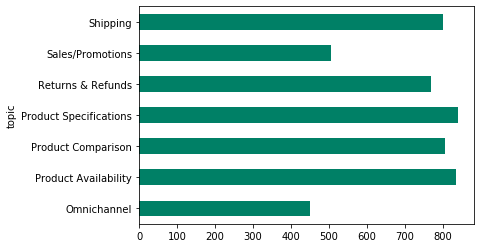

In [23]:
# See the distribution of topics in dataframe
df.groupby('topic').tokens.count().plot(kind="barh",colormap="summer")

#### From the above graph we can see that Sales/Promotions and Omnichannel topics have less questions as compared to the others. So, the dataset is a bit imbalanced.

In [24]:
# Split data into train and validation sets

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

train_x, test_x, train_y, test_y = train_test_split(df['tokens'], df['topic'], test_size=0.2, random_state=32)

# Using LabelEncoder to encode label from text to number

encoder = LabelEncoder()
train_y = encoder.fit_transform(train_y)
test_y = encoder.fit_transform(test_y)

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer

#Word level TF-IDF
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000)
tfidf_vect.fit(df['tokens'])

xtrain_tfidf = tfidf_vect.transform(train_x)
xtest_tfidf = tfidf_vect.transform(test_x)

In [26]:
# Using n-gram level TF-IDF also to see if it performs better than Word TF-IDF.

tfidf_ngram = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)
tfidf_ngram.fit(df['tokens'])

xtrain_ngram = tfidf_ngram.transform(train_x)
xtest_ngram = tfidf_ngram.transform(test_x)

### 1) Multi-class classification model - Naive Bayes

In [27]:
from sklearn.naive_bayes import MultinomialNB

nbModel = MultinomialNB()

#Fitting and Predicting using word TF-IDF data.
nbModel.fit(xtrain_tfidf, train_y)  
nb_predict_y = nbModel.predict(xtest_tfidf)

#Fitting and Predicting using ngram TF-IDF data.
nbModel.fit(xtrain_ngram, train_y)  
nbngram_predict_y = nbModel.predict(xtest_ngram)

In [28]:
#Function to print evaluation metrices.

def evaluate(test,pred):
    print("\nConfusion Matrix for the prediction model:\n")
    print(confusion_matrix(test, pred))

    print("\nClassification Report for the prediction model:\n")
    print(classification_report(test, pred, target_names=df['topic'].unique())) 
    
    print("Accuracy:",accuracy_score(test, pred))

In [29]:
print('Naive Bayes using word TF-IDF:')
evaluate(test_y,nb_predict_y)

Naive Bayes using word TF-IDF:

Confusion Matrix for the prediction model:

[[ 89   0   0   0   4   2   6]
 [  0 151   3   3   1   0   0]
 [  0   3 127  15   1   1   1]
 [  0   2  14 141   3   0   2]
 [  0   0   0   0 176   0   0]
 [  1   2   0   0   1  86   1]
 [  0   0   0   0   1   0 163]]

Classification Report for the prediction model:

                        precision    recall  f1-score   support

      Sales/Promotions       0.99      0.88      0.93       101
              Shipping       0.96      0.96      0.96       158
  Product Availability       0.88      0.86      0.87       148
Product Specifications       0.89      0.87      0.88       162
           Omnichannel       0.94      1.00      0.97       176
    Product Comparison       0.97      0.95      0.96        91
     Returns & Refunds       0.94      0.99      0.97       164

              accuracy                           0.93      1000
             macro avg       0.94      0.93      0.93      1000
          weig

In [30]:
print('Naive Bayes using ngram TF-IDF:')
evaluate(test_y,nbngram_predict_y)

Naive Bayes using ngram TF-IDF:

Confusion Matrix for the prediction model:

[[ 93   1   2   3   0   0   2]
 [  0 132   2  19   2   2   1]
 [  0   4 122  21   0   0   1]
 [  1   5  16 140   0   0   0]
 [  0   0   0   1 174   1   0]
 [  0   2   0   3   0  84   2]
 [  1   0   0   1   0   0 162]]

Classification Report for the prediction model:

                        precision    recall  f1-score   support

      Sales/Promotions       0.98      0.92      0.95       101
              Shipping       0.92      0.84      0.87       158
  Product Availability       0.86      0.82      0.84       148
Product Specifications       0.74      0.86      0.80       162
           Omnichannel       0.99      0.99      0.99       176
    Product Comparison       0.97      0.92      0.94        91
     Returns & Refunds       0.96      0.99      0.98       164

              accuracy                           0.91      1000
             macro avg       0.92      0.91      0.91      1000
          wei

#### Comparing the above two results, we can say that the Naive Bayes model using the train test data created from word TF-IDF performed better than the model using ngram TF-IDF.

### 2) Ensemble model - Random Forest 

In [31]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_split=2)

rf.fit(xtrain_tfidf, train_y)  
rf_predict_y = rf.predict(xtest_tfidf)

In [32]:
print('Random Forest:')
evaluate(test_y,rf_predict_y)

Random Forest:

Confusion Matrix for the prediction model:

[[ 97   0   0   1   0   0   3]
 [  0 155   2   1   0   0   0]
 [  0   1 142   5   0   0   0]
 [  0   6   2 154   0   0   0]
 [  0   1   0   1 174   0   0]
 [  1   1   0   1   1  86   1]
 [  0   0   1   0   0   0 163]]

Classification Report for the prediction model:

                        precision    recall  f1-score   support

      Sales/Promotions       0.99      0.96      0.97       101
              Shipping       0.95      0.98      0.96       158
  Product Availability       0.97      0.96      0.96       148
Product Specifications       0.94      0.95      0.95       162
           Omnichannel       0.99      0.99      0.99       176
    Product Comparison       1.00      0.95      0.97        91
     Returns & Refunds       0.98      0.99      0.98       164

              accuracy                           0.97      1000
             macro avg       0.97      0.97      0.97      1000
          weighted avg       0

#### This model performed fairly well with an accuracy of 97.1. I also ran the Random Forest model with input data created using ngram TFIDF but it didn't perform as good as the model with data using word TF-IDF. 

#### Tuning the model's hyperparameters to see if the performnce can be improved further:

In [61]:
#Hyper parameter tuning of the Random Forest Classifier

from sklearn.model_selection import RandomizedSearchCV

random_grid = {'n_estimators': [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)],
               'max_features': ['auto', 'sqrt','log2'],
               'max_depth': [int(x) for x in np.linspace(10, 110, num = 10)],
               'min_samples_split': [2, 4, 5, 10],
               'min_samples_leaf': [1, 2, 4],
               'bootstrap': [True, False]}

In [62]:
from sklearn.ensemble import RandomForestRegressor

# Random search of parameters, using 3 fold cross validation running 10 iterations
rf_random = RandomizedSearchCV(rf, param_distributions = random_grid, n_iter = 8, cv = 3, verbose=2, random_state=32,n_jobs = -1)

rf_random.fit(xtrain_tfidf, train_y)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


RandomizedSearchCV(cv=3,
                   estimator=RandomForestClassifier(max_depth=110,
                                                    min_samples_leaf=4,
                                                    min_samples_split=5,
                                                    n_estimators=1200),
                   n_iter=8, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 21, 32, 43, 54, 65,
                                                      76, 87, 98, 110],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 4, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1

In [63]:
rf_random.best_estimator_

RandomForestClassifier(max_depth=87, max_features='log2', min_samples_split=4,
                       n_estimators=1200)

In [64]:
rf = RandomForestClassifier(n_estimators=1200, max_depth=87, max_features='log2', min_samples_split=4)

rf.fit(xtrain_tfidf, train_y)  
rf_predict_y_RS = rf.predict(xtest_tfidf)

In [65]:
print('Random Forest using word TF-IDF:')
evaluate(test_y,rf_predict_y_RS)

Random Forest using word TF-IDF:

Confusion Matrix for the prediction model:

[[ 96   0   0   1   0   0   4]
 [  0 152   3   3   0   0   0]
 [  0   0 142   6   0   0   0]
 [  0   3   3 156   0   0   0]
 [  0   0   0   2 174   0   0]
 [  1   0   0   1   0  88   1]
 [  0   0   0   0   0   0 164]]

Classification Report for the prediction model:

                        precision    recall  f1-score   support

      Sales/Promotions       0.99      0.95      0.97       101
              Shipping       0.98      0.96      0.97       158
  Product Availability       0.96      0.96      0.96       148
Product Specifications       0.92      0.96      0.94       162
           Omnichannel       1.00      0.99      0.99       176
    Product Comparison       1.00      0.97      0.98        91
     Returns & Refunds       0.97      1.00      0.98       164

              accuracy                           0.97      1000
             macro avg       0.97      0.97      0.97      1000
          we

#### Using the best parameters from hyperparameter tuning, the performance of the Random Forest model increased slightly.

### 3) Neural Network

In [43]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(alpha = 1,hidden_layer_sizes=(120,),learning_rate='adaptive',activation = 'relu',solver='adam',random_state=1)
mlp.fit(xtrain_tfidf, train_y)  

mlp_predict_y = mlp.predict(xtest_tfidf)

In [44]:
print('Neural Network:')
evaluate(test_y,mlp_predict_y)

Neural Network:

Confusion Matrix for the prediction model:

[[ 95   0   1   0   1   0   4]
 [  0 150   6   2   0   0   0]
 [  0   0 139   9   0   0   0]
 [  0   4   8 150   0   0   0]
 [  0   0   0   2 174   0   0]
 [  1   3   0   1   0  86   0]
 [  0   0   0   0   0   0 164]]

Classification Report for the prediction model:

                        precision    recall  f1-score   support

      Sales/Promotions       0.99      0.94      0.96       101
              Shipping       0.96      0.95      0.95       158
  Product Availability       0.90      0.94      0.92       148
Product Specifications       0.91      0.93      0.92       162
           Omnichannel       0.99      0.99      0.99       176
    Product Comparison       1.00      0.95      0.97        91
     Returns & Refunds       0.98      1.00      0.99       164

              accuracy                           0.96      1000
             macro avg       0.96      0.96      0.96      1000
          weighted avg       

In [45]:
#Hyperparameter tuning for neural network

mlp_grid = {
    'hidden_layer_sizes': [(10,30,10),(20,)],
    'activation': ['tanh', 'relu','sigmoid'],
    'solver': ['sgd','adam','lbfgs'],
    'alpha': [0.0001, 0.05, 0.005, 0.001],
    'learning_rate': ['constant','adaptive','invscaling']
}

In [46]:
mlp_rs = RandomizedSearchCV(mlp, param_distributions = mlp_grid, n_iter = 5, cv = 3, verbose=2, random_state=32,n_jobs = -1)

mlp_rs.fit(xtrain_tfidf, train_y)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


C:\Users\Vikanksha Goley\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:921: UserWarning: One or more of the test scores are non-finite: [0.69775034 0.92624899 0.38374849 0.94949974        nan]
  category=UserWarning


RandomizedSearchCV(cv=3,
                   estimator=MLPClassifier(alpha=1, hidden_layer_sizes=(120,),
                                           learning_rate='adaptive',
                                           random_state=1),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'activation': ['tanh', 'relu',
                                                       'sigmoid'],
                                        'alpha': [0.0001, 0.05, 0.005, 0.001],
                                        'hidden_layer_sizes': [(10, 30, 10),
                                                               (20,)],
                                        'learning_rate': ['constant',
                                                          'adaptive',
                                                          'invscaling'],
                                        'solver': ['sgd', 'adam', 'lbfgs']},
                   random_state=32, verbose=2)

In [47]:
mlp_rs.best_estimator_

MLPClassifier(alpha=0.005, hidden_layer_sizes=(20,), random_state=1)

In [48]:
mlp = MLPClassifier(alpha = 0.005,hidden_layer_sizes=(20,),learning_rate='adaptive',activation = 'relu',solver='adam',random_state=1)
mlp.fit(xtrain_tfidf, train_y)  

mlp_predict_y_RS = mlp.predict(xtest_tfidf)

In [49]:
print('Neural Network:')
evaluate(test_y,mlp_predict_y_RS)

Neural Network:

Confusion Matrix for the prediction model:

[[ 97   0   0   0   0   0   4]
 [  0 151   4   3   0   0   0]
 [  0   1 136  11   0   0   0]
 [  0   2   6 154   0   0   0]
 [  0   0   0   0 176   0   0]
 [  1   0   0   0   0  89   1]
 [  0   0   0   0   0   0 164]]

Classification Report for the prediction model:

                        precision    recall  f1-score   support

      Sales/Promotions       0.99      0.96      0.97       101
              Shipping       0.98      0.96      0.97       158
  Product Availability       0.93      0.92      0.93       148
Product Specifications       0.92      0.95      0.93       162
           Omnichannel       1.00      1.00      1.00       176
    Product Comparison       1.00      0.98      0.99        91
     Returns & Refunds       0.97      1.00      0.98       164

              accuracy                           0.97      1000
             macro avg       0.97      0.97      0.97      1000
          weighted avg       

#### After doing hyperparameter tuning, the performance of the Neural Network model improved. The accuracy increased to 96.7% from 95.8% after hyperparameter tuning. 

### Comparison of the Models and Insights

Comparing the results of different models, we can say that the Random Forest model has performed the best. Below are the details:

1) The diagonal cells from top-left to bottom-right shows the number of correct predictions. By comparing the 3 confusion matrices(Naive Bayes, Tuned Random forest and Tuned Neural Network) , we can see that Random Forest has out-performed the other two models in most of the categories. 

2) Comparing the accuracy of the models we can say that the Random Forest performed best with an accuracy of 97.2% followed by Neural Network with an accuracy of 96.7%.

3) Since the dataset is imbalanced, F1 score would also give a good idea about the performance. Comparing the F1 score we can say the Random Forest performed best followed by Neural Network model.


#### Some other insights are:

1) Hyperparameter tuning helped in improving the performance of the models.

2) Using ngram- TFIDF, the results were not as good as using word TF-IDF vectorization.

In [66]:
df.to_csv('Out_Customer_Service_Questions_Multiclass.csv ')